# Time Series Anaysis

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

# Exploration of the Bay Area Rapid Transit (BART) data
Bay Area Rapid Transit (BART) is a rapid transit public transportation system serving the San Francisco Bay Area in California. The provided dataset includes daily total ridership records in 2017, 2018, and 2019. In this homework, we aim to use trend + seasonality linear regression to predict BART ridership and detect anomalies using the timeseries decomposition method.

In [ ]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv')

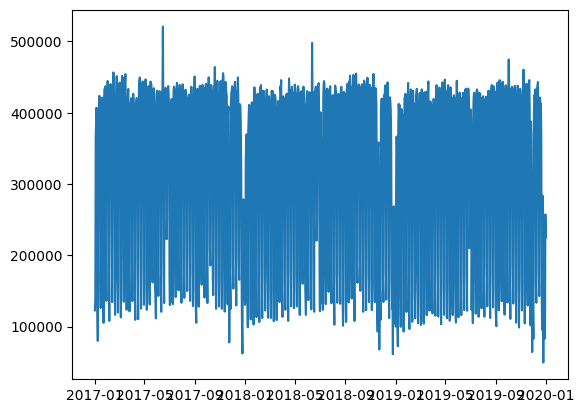

In [ ]:
bart['date'] = pd.to_datetime(bart['date'])
plt.plot(bart['date'],bart['passenger'])

### Task 1, use linear regression to explore the trends over 3 years, and report is there a significant trend in the BART data.
Hint: using the index to represent the day count from the first day.

10 pts. -3 pts if the linear regression summary is missing.

In [ ]:
lm=sm.OLS(bart['passenger'],sm.add_constant(bart.index)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Wed, 07 Feb 2024   Prob (F-statistic):              0.132
Time:                        23:30:07   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

Based on the linear regression report, as the 95\% confidence interval for the coefficient of X1 varialble (day count) contains zero and the p-value is higher than 5\%, the trend is not statistically siginificant.

### Task 2 Find a proper period using scipy.signal.periodogram and autocorrelation

10 pts for finding the period. -3 pts if the figure has an improper ylim.
10 pts for autocorrelation. -5 pts if used the wrong period.

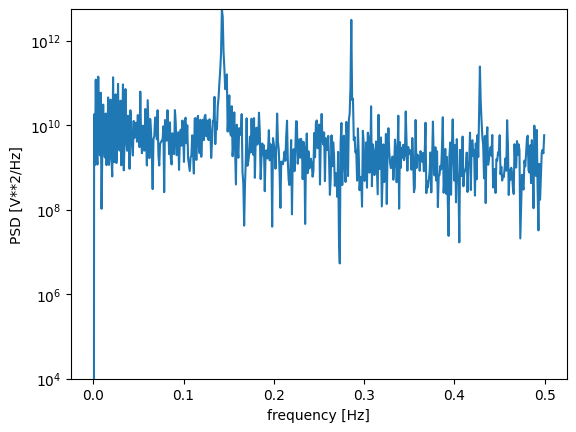

In [ ]:
f, PSD = scipy.signal.periodogram(bart.passenger, 1)
plt.semilogy(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim(10**4,max(PSD))
plt.show()

The strongest period is detected at the frequency around 1/7, corresponding to one week.

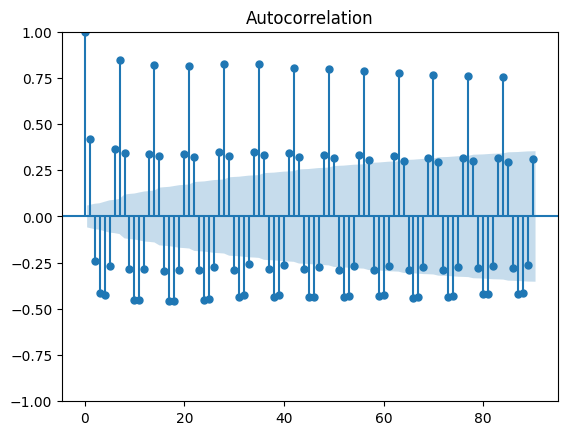

In [ ]:
plot_acf(bart.passenger, lags = 90);

Similarly the autocorrelation peaks also correspond to 7,14,21,... days highlighting a one week period

### Task 3 Build a linear regression for trend+seasonality (using a weekly period with 7 dummy variables for each day of the week) to predict passenger count. Train on 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their significance

In [ ]:
# 3 pts for day of week dummy variable, 7 pts for training dataset, 5 pts for model, 5 pts for model summary
bart['DOW'] = bart['date'].dt.dayofweek
X = pd.concat([pd.DataFrame(range(730),columns=['day']),
               pd.get_dummies(bart['DOW'],drop_first=False)[:730].reset_index(drop=True)],axis=1)
#X = sm.add_constant(X)
lm=sm.OLS(bart.passenger[:730],X).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          3.58e-275
Time:                        23:30:09   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -22.1202      9.170     -2.412      0.0

All day of week variables impact BART ridership statistically significant.

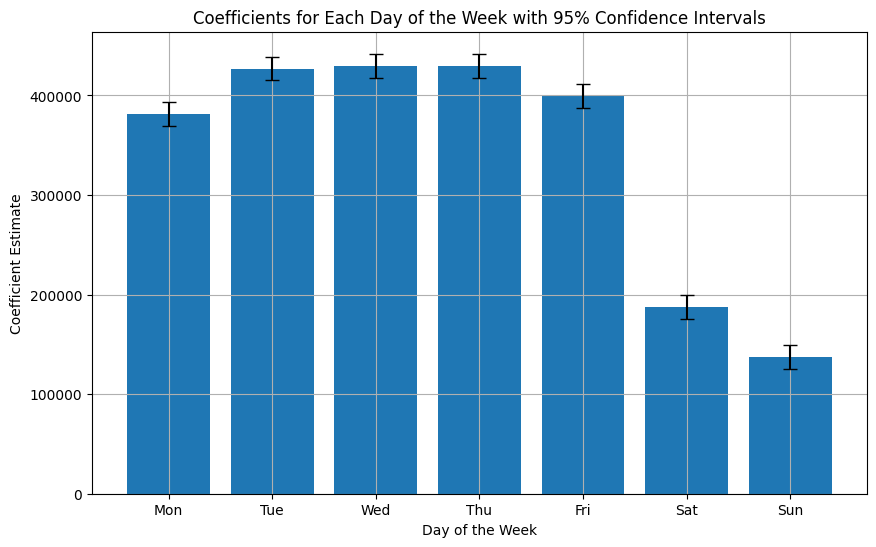

In [ ]:
coef_estimates = lm.params[1:]  # Exclude intercept
conf_intervals = lm.conf_int()[1:]  # Exclude intercept

# Calculate errors
errors = (conf_intervals[1] - conf_intervals[0]) / 2  # Half the confidence interval width

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        lm.params[1:].tolist(),
        yerr=errors,
        capsize=5)
plt.xlabel('Day of the Week')
plt.ylabel('Coefficient Estimate')
plt.title('Coefficients for Each Day of the Week with 95% Confidence Intervals')
plt.grid(True)
plt.show()

### Task 4, plot results and report insample and out-of-sample predictions. Report in-sample and out-of-sample $R^2$

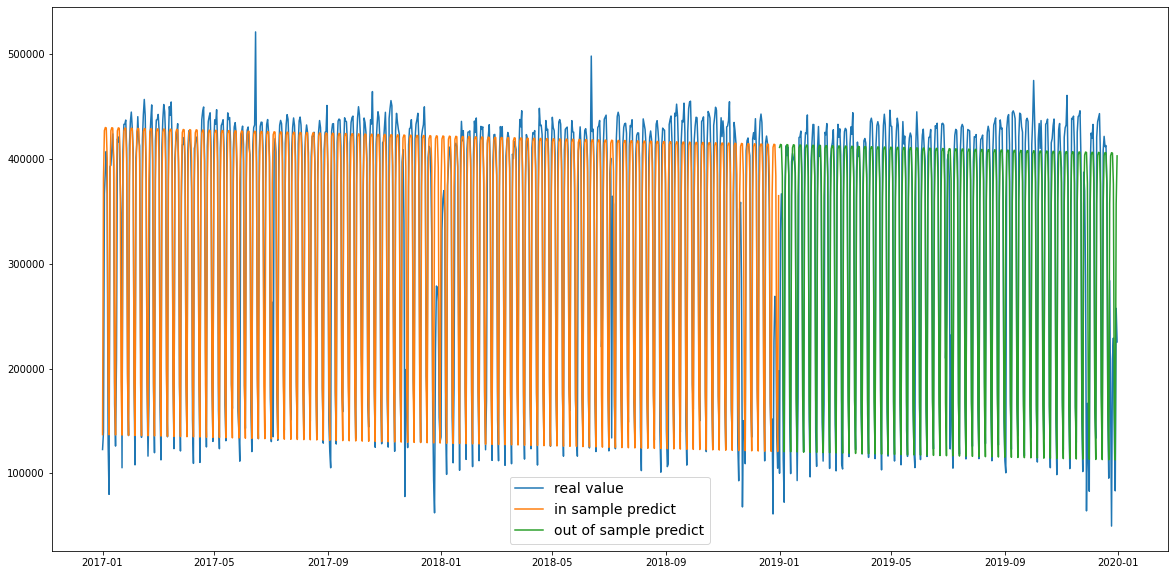

In [ ]:
# 20 pts. -5 if legend is missing. -3 if students did not separate im-sample and out-of-sample
plt.figure(figsize = (20,10))
plt.subplot(111)

plt.plot(bart.date,bart.passenger,label='real value')

inSample = lm.predict(X)
X = pd.concat([pd.DataFrame(range(730,len(bart)),columns=['day']),
               pd.get_dummies(bart['DOW'][730:],drop_first=False).reset_index(drop=True)],axis=1)
#X = sm.add_constant(X)
outofSample = lm.predict(X)

plt.plot(bart.date[:730],inSample,label='in sample predict')
plt.plot(bart.date[730:],outofSample,label='out of sample predict')
plt.legend(fontsize=14)

In [ ]:
# 10pts. 5 pts for each
print('in sample R^2:',r2_score(bart['passenger'][:730],inSample))
print('out of sample R^2:',r2_score(bart['passenger'][730:],outofSample))

in sample R^2: 0.8324941917707158
out of sample R^2: 0.8203089387540557
